In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_series(time,series,start=0,end=None,format='-'):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O sunspots.csv

--2020-07-07 16:51:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘sunspots.csv’

sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2020-07-07 16:51:13 (38.3 MB/s) - ‘sunspots.csv’ saved [70827/70827]



In [4]:
import os
os.listdir()

['.config', 'sunspots.csv', 'sample_data']

In [5]:
mycsv = 'sunspots.csv'
import csv

In [6]:
sunspots = [] ; time_step = []
with open(mycsv,'r') as f:
  reader = csv.reader(f,delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

In [7]:
series = np.array(sunspots)
time = np.array(time_step)

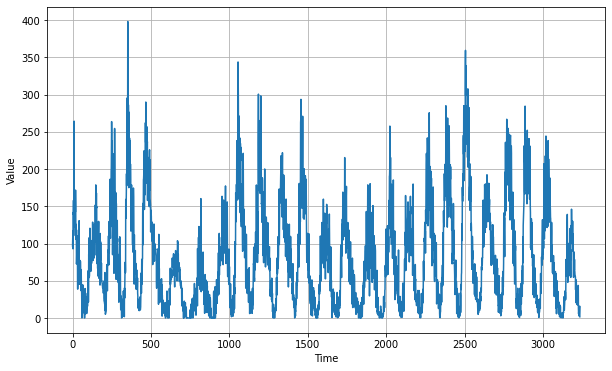

In [8]:
plt.figure(figsize=(10,6))
plot_series(time,series)

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model,series,window_size,batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(batch_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [11]:
def MODEL(series,split_time,window_size,batch_size,shuffle_buffer,Conv1Dn,GRU1n,GRU2n,Dense1,Dense2,Dense3,epochs):
  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  np.random.seed(51)

  split_time = split_time
  time_train = time[:split_time]
  x_train = series[:split_time]
  time_valid = time[split_time:]
  x_valid = series[split_time:]

  dataset = windowed_dataset(series=x_train,window_size=window_size,batch_size=batch_size,shuffle_buffer=shuffle_buffer)

  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv1D(Conv1Dn,kernel_size=5,strides=1,padding='causal',input_shape=[None,1],activation='relu'),
                                      tf.keras.layers.GRU(GRU1n,return_sequences=True),
                                      tf.keras.layers.GRU(GRU2n,return_sequences=True),
                                      tf.keras.layers.Dense(Dense1,activation='relu'),
                                      tf.keras.layers.Dense(Dense2,activation='relu'),
                                      tf.keras.layers.Dense(Dense3),
                                      tf.keras.layers.Lambda(lambda x: x*400)
  ])
  
  model.compile(loss=tf.keras.losses.Huber(),optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['mae'])

  history = model.fit(dataset,epochs=epochs)

  forecast = model_forecast(model,series[...,np.newaxis],window_size=window_size,batch_size=batch_size)
  forecast = forecast[split_time-window_size:-1,-1,0]

  plt.figure(figsize=(10,6))
  plot_series(time_valid,x_valid)
  plot_series(time_valid,forecast)

  print(tf.keras.metrics.mean_absolute_error(x_valid,forecast).numpy())
  return history

Epoch 1/50
23/23 [==============================] - 2s 79ms/step - loss: 60.4846 - mae: 60.9828
Epoch 2/50
23/23 [==============================] - 2s 75ms/step - loss: 33.7931 - mae: 34.2886
Epoch 3/50
23/23 [==============================] - 2s 74ms/step - loss: 30.4028 - mae: 30.8983
Epoch 4/50
23/23 [==============================] - 2s 74ms/step - loss: 33.0978 - mae: 33.5942
Epoch 5/50
23/23 [==============================] - 2s 74ms/step - loss: 26.3656 - mae: 26.8599
Epoch 6/50
23/23 [==============================] - 2s 74ms/step - loss: 25.9253 - mae: 26.4200
Epoch 7/50
23/23 [==============================] - 2s 74ms/step - loss: 26.3205 - mae: 26.8153
Epoch 8/50
23/23 [==============================] - 2s 72ms/step - loss: 25.8277 - mae: 26.3222
Epoch 9/50
23/23 [==============================] - 2s 73ms/step - loss: 25.0475 - mae: 25.5420
Epoch 10/50
23/23 [==============================] - 2s 73ms/step - loss: 24.6904 - mae: 25.1850
Epoch 11/50
23/23 [====================

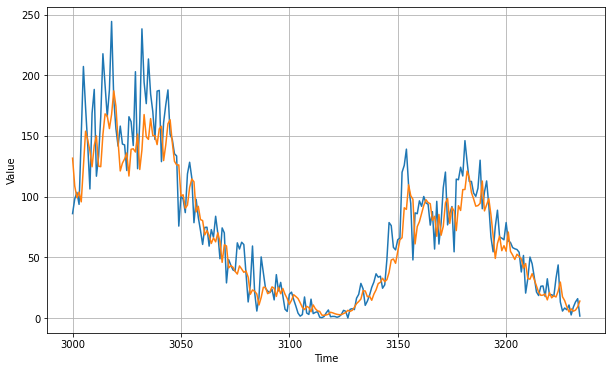

In [12]:
history_32_132 = MODEL(series=series,split_time=3000,window_size=32,batch_size=132,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=64,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
12/12 [==============================] - 3s 256ms/step - loss: 75.3467 - mae: 75.8450
Epoch 2/50
12/12 [==============================] - 3s 241ms/step - loss: 37.4306 - mae: 37.9272
Epoch 3/50
12/12 [==============================] - 3s 249ms/step - loss: 36.3711 - mae: 36.8673
Epoch 4/50
12/12 [==============================] - 3s 249ms/step - loss: 32.8412 - mae: 33.3370
Epoch 5/50
12/12 [==============================] - 3s 250ms/step - loss: 30.8662 - mae: 31.3611
Epoch 6/50
12/12 [==============================] - 3s 253ms/step - loss: 30.5567 - mae: 31.0525
Epoch 7/50
12/12 [==============================] - 3s 249ms/step - loss: 30.3546 - mae: 30.8503
Epoch 8/50
12/12 [==============================] - 3s 253ms/step - loss: 28.9619 - mae: 29.4571
Epoch 9/50
12/12 [==============================] - 3s 254ms/step - loss: 26.9765 - mae: 27.4712
Epoch 10/50
12/12 [==============================] - 3s 251ms/step - loss: 28.1322 - mae: 28.6278
Epoch 11/50
12/12 [==========

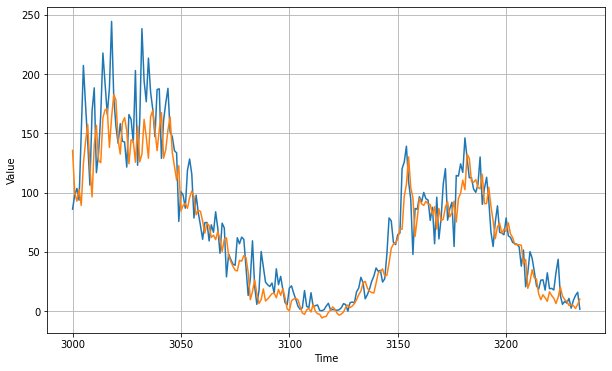

In [13]:
history_64_264 = MODEL(series=series,split_time=3000,window_size=64,batch_size=264,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=64,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
11/11 [==============================] - 6s 506ms/step - loss: 73.1575 - mae: 73.6560
Epoch 2/50
11/11 [==============================] - 6s 511ms/step - loss: 44.4816 - mae: 44.9789
Epoch 3/50
11/11 [==============================] - 6s 509ms/step - loss: 38.1957 - mae: 38.6924
Epoch 4/50
11/11 [==============================] - 6s 502ms/step - loss: 34.8209 - mae: 35.3169
Epoch 5/50
11/11 [==============================] - 6s 513ms/step - loss: 31.8090 - mae: 32.3039
Epoch 6/50
11/11 [==============================] - 6s 503ms/step - loss: 29.9830 - mae: 30.4785
Epoch 7/50
11/11 [==============================] - 6s 506ms/step - loss: 30.2174 - mae: 30.7132
Epoch 8/50
11/11 [==============================] - 6s 509ms/step - loss: 30.5036 - mae: 30.9988
Epoch 9/50
11/11 [==============================] - 6s 510ms/step - loss: 28.9947 - mae: 29.4887
Epoch 10/50
11/11 [==============================] - 6s 514ms/step - loss: 26.6250 - mae: 27.1197
Epoch 11/50
11/11 [==========

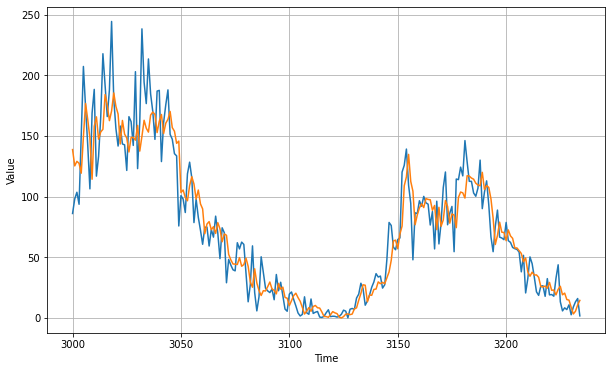

In [14]:
history_128_264 = MODEL(series=series,split_time=3000,window_size=128,batch_size=264,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=64,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
12/12 [==============================] - 2s 192ms/step - loss: 72.9794 - mae: 73.4779
Epoch 2/50
12/12 [==============================] - 2s 192ms/step - loss: 35.6352 - mae: 36.1318
Epoch 3/50
12/12 [==============================] - 2s 190ms/step - loss: 34.2274 - mae: 34.7236
Epoch 4/50
12/12 [==============================] - 2s 190ms/step - loss: 34.2816 - mae: 34.7778
Epoch 5/50
12/12 [==============================] - 2s 190ms/step - loss: 31.1783 - mae: 31.6738
Epoch 6/50
12/12 [==============================] - 2s 188ms/step - loss: 27.7509 - mae: 28.2461
Epoch 7/50
12/12 [==============================] - 2s 188ms/step - loss: 27.1638 - mae: 27.6589
Epoch 8/50
12/12 [==============================] - 2s 190ms/step - loss: 26.7346 - mae: 27.2278
Epoch 9/50
12/12 [==============================] - 2s 189ms/step - loss: 27.1154 - mae: 27.6093
Epoch 10/50
12/12 [==============================] - 2s 191ms/step - loss: 29.3716 - mae: 29.8661
Epoch 11/50
12/12 [==========

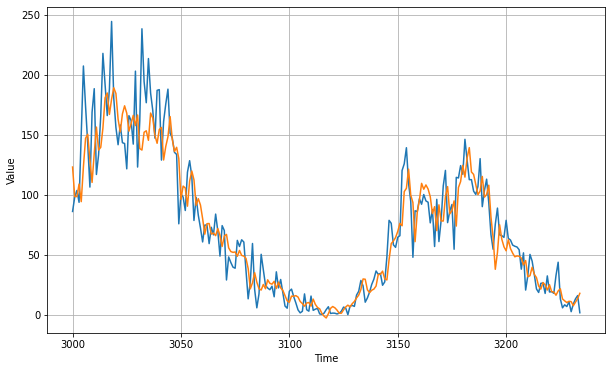

In [15]:
history_48_264 = MODEL(series=series,split_time=3000,window_size=48,batch_size=264,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=64,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
17/17 [==============================] - 3s 152ms/step - loss: 69.3982 - mae: 69.8962
Epoch 2/50
17/17 [==============================] - 3s 152ms/step - loss: 39.7171 - mae: 40.2137
Epoch 3/50
17/17 [==============================] - 3s 153ms/step - loss: 33.7891 - mae: 34.2841
Epoch 4/50
17/17 [==============================] - 3s 152ms/step - loss: 31.6439 - mae: 32.1398
Epoch 5/50
17/17 [==============================] - 3s 152ms/step - loss: 29.4995 - mae: 29.9952
Epoch 6/50
17/17 [==============================] - 3s 152ms/step - loss: 26.4909 - mae: 26.9860
Epoch 7/50
17/17 [==============================] - 3s 153ms/step - loss: 24.9174 - mae: 25.4117
Epoch 8/50
17/17 [==============================] - 3s 153ms/step - loss: 22.7014 - mae: 23.1951
Epoch 9/50
17/17 [==============================] - 3s 153ms/step - loss: 22.4389 - mae: 22.9331
Epoch 10/50
17/17 [==============================] - 3s 155ms/step - loss: 22.1497 - mae: 22.6437
Epoch 11/50
17/17 [==========

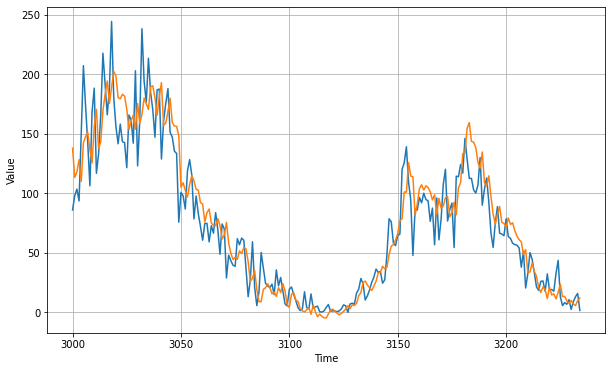

In [16]:
history_60_180 = MODEL(series=series,split_time=3000,window_size=60,batch_size=180,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=64,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
17/17 [==============================] - 2s 132ms/step - loss: 61.5112 - mae: 62.0092
Epoch 2/50
17/17 [==============================] - 2s 126ms/step - loss: 35.6660 - mae: 36.1620
Epoch 3/50
17/17 [==============================] - 2s 125ms/step - loss: 35.0805 - mae: 35.5761
Epoch 4/50
17/17 [==============================] - 2s 125ms/step - loss: 32.5892 - mae: 33.0853
Epoch 5/50
17/17 [==============================] - 2s 132ms/step - loss: 31.3335 - mae: 31.8290
Epoch 6/50
17/17 [==============================] - 2s 128ms/step - loss: 31.2409 - mae: 31.7367
Epoch 7/50
17/17 [==============================] - 3s 150ms/step - loss: 27.3367 - mae: 27.8315
Epoch 8/50
17/17 [==============================] - 2s 135ms/step - loss: 28.4447 - mae: 28.9393
Epoch 9/50
17/17 [==============================] - 2s 132ms/step - loss: 30.2033 - mae: 30.6982
Epoch 10/50
17/17 [==============================] - 2s 124ms/step - loss: 26.1778 - mae: 26.6720
Epoch 11/50
17/17 [==========

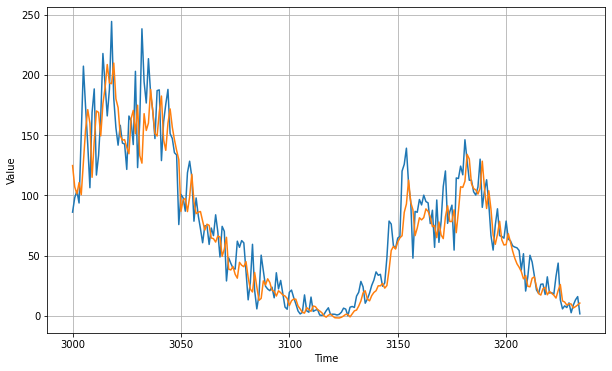

In [17]:
history_60_180 = MODEL(series=series,split_time=3000,window_size=60,batch_size=180,shuffle_buffer=100,Conv1Dn=32,GRU1n=64,GRU2n=32,Dense1=32,Dense2=16,Dense3=1,epochs=50)

Epoch 1/50
17/17 [==============================] - 3s 158ms/step - loss: 72.7188 - mae: 73.2168
Epoch 2/50
17/17 [==============================] - 3s 157ms/step - loss: 32.7758 - mae: 33.2721
Epoch 3/50
17/17 [==============================] - 3s 156ms/step - loss: 35.1345 - mae: 35.6312
Epoch 4/50
17/17 [==============================] - 3s 155ms/step - loss: 28.7217 - mae: 29.2173
Epoch 5/50
17/17 [==============================] - 3s 155ms/step - loss: 25.0783 - mae: 25.5731
Epoch 6/50
17/17 [==============================] - 3s 156ms/step - loss: 27.3991 - mae: 27.8939
Epoch 7/50
17/17 [==============================] - 3s 156ms/step - loss: 24.7145 - mae: 25.2088
Epoch 8/50
17/17 [==============================] - 3s 155ms/step - loss: 28.3081 - mae: 28.8032
Epoch 9/50
17/17 [==============================] - 3s 154ms/step - loss: 23.4167 - mae: 23.9101
Epoch 10/50
17/17 [==============================] - 3s 155ms/step - loss: 19.9948 - mae: 20.4867
Epoch 11/50
17/17 [==========

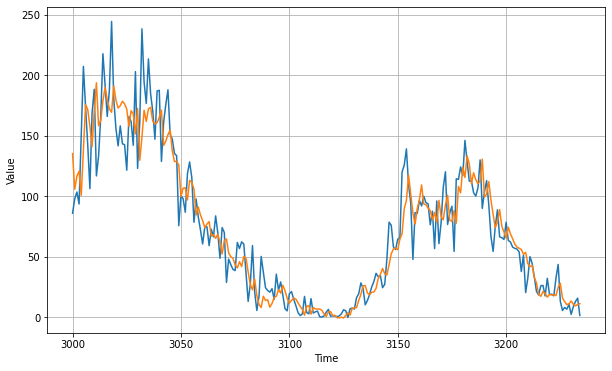

In [18]:
history_60_180_gru60 = MODEL(series=series,split_time=3000,window_size=60,batch_size=180,shuffle_buffer=100,Conv1Dn=32,GRU1n=60,GRU2n=60,Dense1=30,Dense2=15,Dense3=1,epochs=50)

Epoch 1/50
17/17 [==============================] - 5s 275ms/step - loss: 84.1855 - mae: 84.6831
Epoch 2/50
17/17 [==============================] - 5s 273ms/step - loss: 34.0095 - mae: 34.5058
Epoch 3/50
17/17 [==============================] - 5s 271ms/step - loss: 28.8610 - mae: 29.3560
Epoch 4/50
17/17 [==============================] - 5s 271ms/step - loss: 30.3735 - mae: 30.8697
Epoch 5/50
17/17 [==============================] - 5s 272ms/step - loss: 26.1767 - mae: 26.6715
Epoch 6/50
17/17 [==============================] - 5s 274ms/step - loss: 25.2794 - mae: 25.7743
Epoch 7/50
17/17 [==============================] - 5s 269ms/step - loss: 24.9481 - mae: 25.4425
Epoch 8/50
17/17 [==============================] - 5s 273ms/step - loss: 22.2785 - mae: 22.7723
Epoch 9/50
17/17 [==============================] - 5s 275ms/step - loss: 24.0913 - mae: 24.5858
Epoch 10/50
17/17 [==============================] - 5s 272ms/step - loss: 22.2159 - mae: 22.7102
Epoch 11/50
17/17 [==========

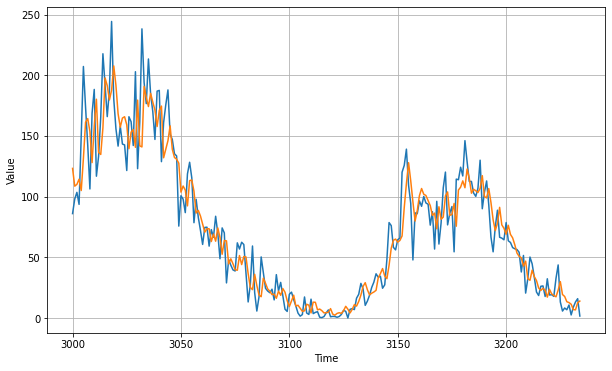

In [23]:
history_60_180_increase = MODEL(series=series,split_time=3000,window_size=60,batch_size=180,shuffle_buffer=100,Conv1Dn=32,GRU1n=120,GRU2n=60,Dense1=30,Dense2=15,Dense3=1,epochs=50)

In [23]:
#its almost equivalen to the graph 

In [24]:
#got a mae of 14.517